In [515]:
import numpy as np
from numpy import zeros
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow import keras
from PIL import Image
import scipy.io
from tensorflow.python.keras.optimizer_v2.gradient_descent import SGD
from matplotlib import pyplot


In [516]:
def image():
    fichier = open('../../asset/Train/Keras/test/wider_face_train_bbx_gt.txt ', 'r')
    mat = scipy.io.loadmat('../../asset/Train/Keras/test/wider_face_train.mat')

    numCat = random.randint(0,len(mat['file_list'])-1)
    numObject =  random.randint(0,len(mat['file_list'][numCat][0])-1)
    numCatReel = mat['file_list'][numCat][0][numObject][0][0].split("_")[0]
    for dir in os.listdir('../../asset/Train/Keras/WIDER_train/images'):
        if dir.split("-")[0] == numCatReel:
            break
    chemin=dir+"/"+mat['file_list'][numCat][0][numObject][0][0]+".jpg"
    return chemin,mat['face_bbx_list'][numCat][0][numObject][0]


In [556]:
def objectTrain(nbImages):
    lImg = []
    lLabel = []
    for i in range(nbImages):
        chemin,boxs = image()
        img = tf.keras.preprocessing.image.load_img("../../asset/Train/Keras/WIDER_train/images/"+chemin)
        img2 = keras.preprocessing.image.img_to_array(img)
        lImg.append(img2)
        masks = zeros([img2.shape[0], img2.shape[1], len(boxs)], dtype='uint8')
        i = 0
        for box in boxs:
            row_s, row_l = box[1], box[3]
            col_s, col_l = box[0], box[2]
            masks[row_s:row_s+row_l, col_s:col_s+col_l, i] = 1
            i=i+1
        lLabel.append(boxs.tolist())
        pyplot.imshow(img)
        for j in range(masks.shape[2]):
            pyplot.imshow(masks[:, :, j], cmap='gray', alpha=0.3)
        pyplot.show()
        print(masks.shape)
    lImg = np.array(lImg)
    lLabel = np.array(lLabel)
    return lImg, lLabel 

In [557]:
def modele():
        cnn = keras.models.Sequential()

        cnn.add(keras.layers.Convolution2D(32, 3, padding='same',  activation='relu', input_shape=(1700,1024,3)))
        cnn.add(keras.layers.Convolution2D(32, 3, 3, activation='relu'))
        cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        cnn.add(keras.layers.Dropout(0.25))

        cnn.add(keras.layers.Convolution2D(64, 3, padding='same',  activation='relu'))
        cnn.add(keras.layers.Convolution2D(64, 3, 3, activation='relu'))
        cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        cnn.add(keras.layers.Dropout(0.25))

        cnn.add(keras.layers.Flatten())
        cnn.add(keras.layers.Dense(512 ,  activation='relu'))
        cnn.add(keras.layers.Dropout(0.5))
        cnn.add(keras.layers.Dense(4, activation = 'softmax'))
        #cnn.summary()

        opt = SGD(lr=0.01, decay=1e-65, momentum=0.92, nesterov=True)

        cnn.compile(loss='categorical_crossentropy',
                         optimizer=opt,
                         metrics='accuracy')
        return cnn

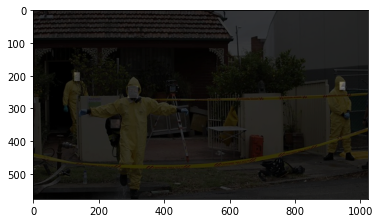

(577, 1024, 4)


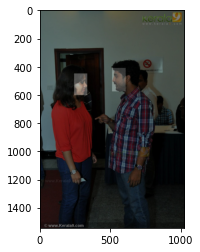

(1543, 1024, 2)


In [562]:
objects, labels = objectTrain(2)

In [563]:
print(labels)

[list([[237, 334, 28, 27], [290, 231, 32, 38], [126, 190, 17, 27], [937, 219, 18, 25]])
 list([[509, 410, 96, 166], [241, 449, 93, 154]])]


In [564]:
def train(n_epochs=20, batch=32):
    cnn = modele()
    cnn.fit(objects, labels,
        batch_size=batch,
        epochs=n_epochs, shuffle=True)


In [565]:
train()

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).